In [1]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import metrics as mc
from scipy.stats import entropy

cf = yaml.safe_load(Path('config.yml').read_text())

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = dataloader.load()
dists, labels, words, sem_col_translator = data['dists'],data['labels'],data['words'],data['translator']

In [3]:
dists_entropies = np.apply_along_axis(mc.shannon_entropy,1,dists.to_numpy())
dists_entropies = pd.DataFrame(dists_entropies,index=dists.index,columns=['e']).reset_index()
dists_entropies = dists_entropies.groupby(dists_entropies.date.dt.to_period('M')).mean().reset_index()
dists_entropies['e_afa'] = adaptive_filter(dists_entropies.e)

/tmp/ipykernel_4028/3974953498.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dists_entropies = dists_entropies.groupby(dists_entropies.date.dt.to_period('M')).mean().reset_index()


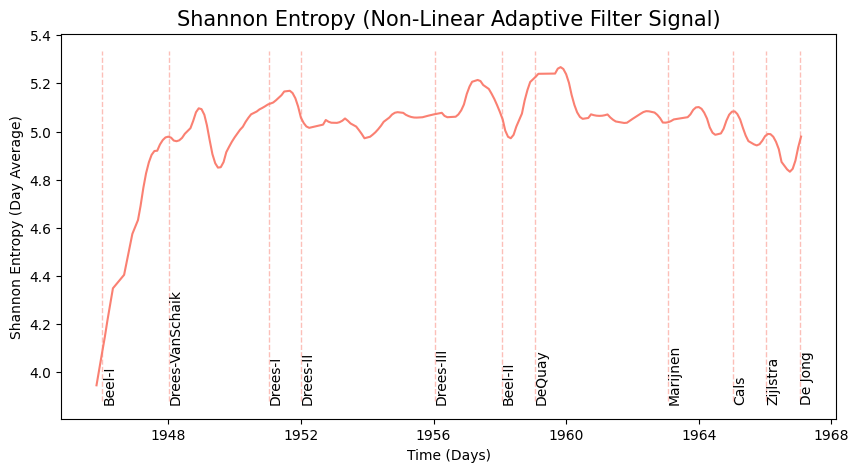

In [4]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(dists_entropies.date.dt.to_timestamp(),dists_entropies.e_afa,color='salmon')
ax.set_xlabel('Time (Days)')
ax.set_ylabel('Shannon Entropy (Day Average)')
ax.set_title('Shannon Entropy (Non-Linear Adaptive Filter Signal)',fontsize=15)
add_cabinet_periods(ax)
# plt.savefig('figs/shannon-entropy-month.pdf',dpi=250,bbox_inches='tight')
plt.show()